In [1]:
import ee
ee.Initialize()
# ee.Authenticate()

ALTM_199_LAKES = ee.FeatureCollection('projects/ee-mazarderakhsh/assets/ALAP-ALTM-195-centroids') \
    .filter(ee.Filter.gte('Field1', 1)) \
    .filter(ee.Filter.lte('Field1', 199))  # pick only ALTM lakes

# Convert the lakes FeatureCollection to a List
lakesList = ALTM_199_LAKES.toList(ALTM_199_LAKES.size())

199 Lakes

Landsat 5

In [2]:
import pandas as pd
import ee

ee.Initialize()

# Define the Landsat 5 bands and their corresponding standard names
LC5_BANDS = ['ST_B6']
STD_NAMES = ['temp_satellite']

# all_lakes=ee.FeatureCollection('projects/ee-mazarderakhsh/assets/ALAP-ALTM-Lakes-195')

def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    waterMask = image.select('QA_PIXEL').eq(5440).Or(image.select('QA_PIXEL').eq(5504))
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(qaMask).updateMask(saturationMask).updateMask(waterMask)



# Define a function to compute the mean reflectance values for the specified bands within the region of interest (lake)
def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)

# Initialize an empty list to store the dataframes for each lake
dfs = []



# # Filter out rows with empty latitude or longitude values
# df_coord_filtered = df_coord[(df_coord['Lat'].notnull()) & (df_coord['Lon'].notnull())]

for i in range(lakesList.size().getInfo()):
    lake = ee.Feature(lakesList.get(i))
    lat = ee.Number(lake.geometry().coordinates().get(1))
    lon = ee.Number(lake.geometry().coordinates().get(0))
    lake_point = ee.Geometry.Point([lon, lat]).buffer(90)
    lakeName = ee.String(lake.get('NAME')).getInfo()
    lakeID = ee.String(lake.get('Field1')).getInfo()

    lat_value = float(ee.Number(lake.geometry().coordinates().get(1)).getInfo())
    lon_value = float(ee.Number(lake.geometry().coordinates().get(0)).getInfo())




  
 
    # Retrieve Landsat 5 imagery for the specific lake
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filter(ee.Filter.calendarRange(1, 12, 'month')) \
        .filterBounds(lake_point) \
        .filter(ee.Filter.lt('CLOUD_COVER', 50)) \
        .map(maskL457sr) \
        .select(LC5_BANDS, STD_NAMES)

    # Map the reflectance function over the Landsat 5 ImageCollection for the specific lake
    map_reflectance = l5.map(lambda img: reflectance(img, lake_point))

    # Reduce the mapped image collection to get reflectance values for the specific lake
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a pandas DataFrame
    df_reflectance = pd.DataFrame(list_reflectance.getInfo(), columns=['DATE_SMP', 'reflectance'])
    df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
    df_reflectance['DATE_SMP'] = df_reflectance['DATE_SMP'].dt.date
    df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})

    # Unpack the 'reflectance' dictionary and create separate columns for each band
    df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                                df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')], axis=1)
    
    df_reflectance['SITE_ID'] = lakeID
    df_reflectance['SITE_NAME'] = lakeName
    df_reflectance['Lon'] = lon_value
    df_reflectance['Lat'] = lat_value

    # Add the DataFrame to the list
    dfs.append(df_reflectance)


# Concatenate all DataFrames into a single DataFrame
df_all_lakes_Landsat5 = pd.concat(dfs, ignore_index=True)

# Sort the DataFrame by 'DATE_SMP' in ascending order
df_all_lakes_Landsat5.sort_values(by='DATE_SMP', inplace=True)

# df_all_lakes.dropna(inplace=True)
df_all_lakes_Landsat5

,DATE_SMP,temp_satellite,SITE_ID,SITE_NAME,Lon,Lat
67767,1984-03-24,NaN,191,South Lake,-74.895066,43.509919
21342,1984-03-24,NaN,51,Irving Pond,-74.470992,43.166234
80816,1984-03-24,NaN,37,Garnet Lake,-74.024074,43.527939
31151,1984-03-24,NaN,33,Fourth Lake,-74.859968,43.753574
49228,1984-03-24,NaN,195,West Pond,-74.881100,43.810806
...,...,...,...,...,...,...
5910,2011-10-09,19.736522,169,Grass Pond,-74.495633,44.656983
70976,2011-10-09,15.769756,42,Heavens Lake,-74.425571,44.130394
60224,2011-10-09,12.658985,172,Lake Colden,-73.979612,44.122702
82588,2011-10-09,16.978240,93,Mink Pond,-74.128038,43.845235


In [3]:
# Remove duplicates from specified columns
df_all_lakes_Landsat5 = df_all_lakes_Landsat5.drop_duplicates(subset=['DATE_SMP', 'SITE_ID', 'SITE_NAME', 'Lon', 'Lat'])
df_all_lakes_Landsat5.dropna(inplace=True)

# Now df_all_lakes_Landsat8 has duplicates removed from the specified columns
df_all_lakes_Landsat5

C:\Users\Faculty\AppData\Local\Temp\ipykernel_17936\3381585223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_lakes_Landsat5.dropna(inplace=True)


,DATE_SMP,temp_satellite,SITE_ID,SITE_NAME,Lon,Lat
41528,1984-03-24,-14.605877,163,Carry Pond,-74.488628,43.682272
35638,1984-04-14,-3.196526,123,Simon Pond,-74.438686,44.192848
23409,1984-05-07,1.565284,193,Squaw Lake,-74.739247,43.633071
55557,1984-05-07,11.869119,124,Slang Pond,-74.379331,44.364131
59613,1984-05-07,9.111355,1,Alford Pond,-74.036707,44.261358
...,...,...,...,...,...,...
5910,2011-10-09,19.736522,169,Grass Pond,-74.495633,44.656983
70976,2011-10-09,15.769756,42,Heavens Lake,-74.425571,44.130394
60224,2011-10-09,12.658985,172,Lake Colden,-73.979612,44.122702
82588,2011-10-09,16.978240,93,Mink Pond,-74.128038,43.845235


In [4]:
# Define the file path for the Excel file
excel_file_path = 'Landsat_5_199Lakes_4232024_WaterMask.xlsx'

# Export the DataFrame to Excel
df_all_lakes_Landsat5.to_excel(excel_file_path, index=False)

print("DataFrame successfully exported to Excel file:", excel_file_path)

DataFrame successfully exported to Excel file: Landsat_5_199Lakes_4232024_WaterMask.xlsx


In [5]:
import pandas as pd
from scipy import stats
import numpy as np


# Create a list to store the results
results = []
df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])

# Loop over each lake in the DataFrame
for lake_id, lake_data in df_all_lakes_Landsat5.groupby('SITE_ID'):
    pond_n = df_all_lakes_Landsat5.loc[df_all_lakes_Landsat5['SITE_ID'] == lake_id, 'SITE_NAME'].iloc[0]

    # Combine data for June, July, and August
    summer_data = lake_data[lake_data['DATE_SMP'].dt.month.isin([1,2,3,4,5,6, 7, 8,9,10,11,12])]
    
    # Remove NaN or blank values from x_values and corresponding y_values
    x_values = summer_data['DATE_SMP'].values.astype(np.int64) // (10 ** 9)  # Convert to seconds
    y_values = summer_data['temp_satellite'].values
    mask = ~np.isnan(x_values) & ~np.isnan(y_values)
    x_values = x_values[mask]
    y_values = y_values[mask]
    
    # Check if x and y contain more than one distinct value
    if len(np.unique(x_values)) > 1:
        slope, _, r_value, p_value, _ = stats.linregress(x_values, y_values)
        
        # Check if the trend is significant (p-value < 0.05)
        if p_value < 0.05:
            slope_per_decade = slope * 10 * 365 * 24 * 3600  # Convert to °C/decade
            result = {
                'Lake_ID': lake_id,
                'Lake_name': pond_n,
                'Month': 'Annual',
                'Slope_per_Decade': slope_per_decade,
                'P-value': p_value,
                'R-value': r_value,
                'Temp_satellite': y_values.mean()  # Calculate mean temperature for non-blank values
            }
            results.append(result)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('significant_slopes_L5_199_Annual_4232024_WaterMask.csv', index=False)

print("Results saved to significant_slopes_L5_1000_Annual_4122024_1.csv")


C:\Users\Faculty\AppData\Local\Temp\ipykernel_17936\2216631018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])


Results saved to significant_slopes_L5_1000_Annual_4122024_1.csv


In [6]:
import pandas as pd
from scipy import stats
import numpy as np


# Create a list to store the results
results = []
df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])

# Loop over each lake in the DataFrame
for lake_id, lake_data in df_all_lakes_Landsat5.groupby('SITE_ID'):
    pond_n = df_all_lakes_Landsat5.loc[df_all_lakes_Landsat5['SITE_ID'] == lake_id, 'SITE_NAME'].iloc[0]

    # Combine data for June, July, and August
    summer_data = lake_data[lake_data['DATE_SMP'].dt.month.isin([6, 7, 8])]
    
    # Remove NaN or blank values from x_values and corresponding y_values
    x_values = summer_data['DATE_SMP'].values.astype(np.int64) // (10 ** 9)  # Convert to seconds
    y_values = summer_data['temp_satellite'].values
    mask = ~np.isnan(x_values) & ~np.isnan(y_values)
    x_values = x_values[mask]
    y_values = y_values[mask]
    
    # Check if x and y contain more than one distinct value
    if len(np.unique(x_values)) > 1:
        slope, _, r_value, p_value, _ = stats.linregress(x_values, y_values)
        
        # Check if the trend is significant (p-value < 0.05)
        if p_value < 0.05:
            slope_per_decade = slope * 10 * 365 * 24 * 3600  # Convert to °C/decade
            result = {
                'Lake_ID': lake_id,
                'Lake_name': pond_n,
                'Month': 'June-August',
                'Slope_per_Decade': slope_per_decade,
                'P-value': p_value,
                'R-value': r_value,
                'Temp_satellite': y_values.mean()  # Calculate mean temperature for non-blank values
            }
            results.append(result)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('significant_slopes_L5_199_SUMMER_4232024_WaterMask.csv', index=False)

print("Results saved to significant_slopes_L5_1000_SUMMER_4122024_1.csv")


C:\Users\Faculty\AppData\Local\Temp\ipykernel_17936\2546249172.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])


Results saved to significant_slopes_L5_1000_SUMMER_4122024_1.csv


In [7]:
import pandas as pd
from scipy import stats
import numpy as np

# Create a list to store the results
results = []
df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])

# Loop over each lake in the DataFrame
for lake_id, lake_data in df_all_lakes_Landsat5.groupby('SITE_ID'):
    pond_n = df_all_lakes_Landsat5.loc[df_all_lakes_Landsat5['SITE_ID'] == lake_id, 'SITE_NAME'].iloc[0]

    # Combine data for June, July, and August
    summer_data = lake_data[lake_data['DATE_SMP'].dt.month.isin([5,6, 7, 8,9,10,11])]
    
    # Filter out rows with NaN values
    summer_data = summer_data.dropna(subset=['temp_satellite'])
    
    # Check if the data is not empty
    if not summer_data.empty:
        # Compute the linear regression
        x_values = summer_data['DATE_SMP'].values.astype(np.int64) // (10 ** 9)  # Convert to seconds
        y_values = summer_data['temp_satellite'].values
        
        # Check if x and y contain more than one value
        if len(x_values) > 1:
            slope, _, r_value, p_value, _ = stats.linregress(x_values, y_values)
            
            # Check if the trend is significant (p-value < 0.05)
            if p_value < 0.05:
                slope_per_decade = slope * 10 * 365 * 24 * 3600  # Convert to °C/decade
                result = {
                    'Lake_ID': lake_id,
                    'Lake_name': pond_n,
                    'Month': 'May-November',
                    'Slope_per_Decade': slope_per_decade,
                    'P-value': p_value,
                    'R-value': r_value,
                    'Temp_satellite': y_values.mean()  # Calculate mean temperature
                }
                results.append(result)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('significant_slopes_L5_199_May_November_4232024_WaterMask.csv', index=False)

print("Results saved to significant_slopes_L5_1000_May_November_4122024_1.csv")

C:\Users\Faculty\AppData\Local\Temp\ipykernel_17936\4219931061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])


Results saved to significant_slopes_L5_1000_May_November_4122024_1.csv


In [8]:
import pandas as pd
from scipy import stats
import numpy as np

# Create a list to store the results
results = []
df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])

# Loop over each lake in the DataFrame
for lake_id, lake_data in df_all_lakes_Landsat5.groupby('SITE_ID'):
    pond_n = df_all_lakes_Landsat5.loc[df_all_lakes_Landsat5['SITE_ID'] == lake_id, 'SITE_NAME'].iloc[0]

    # Loop over each month
    for month in range(1, 13):
        month_data = lake_data[lake_data['DATE_SMP'].dt.month == month]

        # Remove NaN or blank values from x_values and corresponding y_values
        x_values = month_data['DATE_SMP'].values.astype(np.int64) // (10 ** 9)  # Convert to seconds
        y_values = month_data['temp_satellite'].values
        mask = ~np.isnan(x_values) & ~np.isnan(y_values)
        x_values = x_values[mask]
        y_values = y_values[mask]

        # Check if x and y contain more than one distinct value
        if len(np.unique(x_values)) > 1:
            slope, _, r_value, p_value, _ = stats.linregress(x_values, y_values)

            # Check if the trend is significant (p-value < 0.05)
            if p_value < 0.05:
                slope_per_decade = slope * 10 * 365 * 24 * 3600  # Convert to °C/decade
                result = {
                    'Lake_ID': lake_id,
                    'Lake_name': pond_n,
                    'Month': month,
                    'Slope_per_Decade': slope_per_decade,
                    'P-value': p_value,
                    'R-value': r_value,
                    'Temp_satellite': y_values.mean()  # Calculate mean temperature for non-blank values
                }
                results.append(result)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('significant_slopes_L5_199_Monthly_4232024_WaterMask.csv', index=False)

print("Results saved to significant_slopes_L5_1000_Monthly_4122024_1.csv")


C:\Users\Faculty\AppData\Local\Temp\ipykernel_17936\2975909412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])


Results saved to significant_slopes_L5_1000_Monthly_4122024_1.csv


In [9]:
import pandas as pd
from scipy import stats
import numpy as np

# Create a list to store the results
results = []
df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])

# Loop over each lake in the DataFrame
for lake_id, lake_data in df_all_lakes_Landsat5.groupby('SITE_ID'):
    pond_n = df_all_lakes_Landsat5.loc[df_all_lakes_Landsat5['SITE_ID'] == lake_id, 'SITE_NAME'].iloc[0]

    # Loop over each month
    for month in range(1, 13):
        month_data = lake_data[lake_data['DATE_SMP'].dt.month == month]

        # Remove NaN or blank values from x_values and corresponding y_values
        x_values = month_data['DATE_SMP'].values.astype(np.int64) // (10 ** 9)  # Convert to seconds
        y_values = month_data['temp_satellite'].values
        mask = ~np.isnan(x_values) & ~np.isnan(y_values)
        x_values = x_values[mask]
        y_values = y_values[mask]

        # Check if x and y contain more than one distinct value
        if len(np.unique(x_values)) > 1:
            slope, _, r_value, p_value, _ = stats.linregress(x_values, y_values)

            slope_per_decade = slope * 10 * 365 * 24 * 3600  # Convert to °C/decade
            result = {
                'Lake_ID': lake_id,
                'Lake_name': pond_n,
                'Month': month,
                'Slope_per_Decade': slope_per_decade,
                'P-value': p_value,
                'R-value': r_value,
                'Temp_satellite': y_values.mean()  # Calculate mean temperature for non-blank values
            }
            results.append(result)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('significant_slopes_L5_199_Monthly_4232024_RemovePValue_WaterMask.csv', index=False)

print("Results saved to significant_slopes_L5_50_Monthly_4232024.csv")


C:\Users\Faculty\AppData\Local\Temp\ipykernel_17936\633128218.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_lakes_Landsat5['DATE_SMP'] = pd.to_datetime(df_all_lakes_Landsat5['DATE_SMP'])


Results saved to significant_slopes_L5_50_Monthly_4232024.csv


In [10]:
import pandas as pd

# Assuming df_all_lakes_Landsat5 is your DataFrame containing Landsat 5 data

# Create an empty list to store the results
results = []

# Loop over each lake in the DataFrame
for lake_id, lake_data in df_all_lakes_Landsat5.groupby('SITE_ID'):
    pond_n = lake_data['SITE_NAME'].iloc[0]  # Get the lake name
    
    # Filter data for the specified years and summer months
    summer_data_2009_2011 = lake_data[
        (lake_data['DATE_SMP'].dt.year >= 2009) & 
        (lake_data['DATE_SMP'].dt.year <= 2011) & 
        (lake_data['DATE_SMP'].dt.month.isin([6, 7, 8]))
    ]
    
    # Calculate the average mean temperature for summer
    average_mean_temp = summer_data_2009_2011['temp_satellite'].mean()
    
    # Append the result to the results list
    results.append({
        'Lake_ID': lake_id,
        'Lake_name': pond_n,
        'Average_mean_temp': average_mean_temp
    })

# Create a DataFrame from the results
average_temps_df = pd.DataFrame(results)

# Save the results to a CSV file
average_temps_df.to_csv('average_mean_temps_landsat5_summer_2009_2011_199Lakes_WaterMask.csv', index=False)

print("Average mean temperatures saved to average_mean_temps_landsat5_summer_2009_2011.csv")


Average mean temperatures saved to average_mean_temps_landsat5_summer_2009_2011.csv


199 Lakes

In [8]:
##### this block calculates temp trends over 199 lakes 
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize()

all_lakes = ee.FeatureCollection('projects/ee-mazarderakhsh/assets/ALAP-ALTM-195-centroids') \
    .filter(ee.Filter.gte('Field1', 1)) \
    .filter(ee.Filter.lte('Field1', 199))  # pick only ALTM lakes

# Convert the lakes FeatureCollection to a List
lakesList = all_lakes.toList(all_lakes.size())

# Define the Landsat 5 bands and their corresponding standard names
LC5_BANDS = ['ST_B6', 'QA_PIXEL']
L8_BANDS = ['ST_B10', 'QA_PIXEL']


STD_NAMES = ['temp', 'QA']

# Define a function to mask clouds and cloud shadows from Landsat 5 surface reflectance imagery
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    waterMask = image.select('QA_PIXEL').eq(5440).Or(image.select('QA_PIXEL').eq(5504))
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(qaMask).updateMask(
        saturationMask).updateMask(waterMask)

def maskL8sr(image):
    # Define cloud, cloud shadow, and cirrus bitmasks
    cloud_shadow_bit_mask = 1 << 3
    cloud_cirrus_bit_mask = 1 << 2
    clouds_bit_mask = 1 << 4

    # Get the pixel QA band
    qa = image.select('QA_PIXEL')
    # Create masks for cloud, cloud shadow, and cirrus
    cloud_shadow_mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0)
    clouds_mask = qa.bitwiseAnd(clouds_bit_mask).eq(0)
    cirrus_mask = qa.bitwiseAnd(cloud_cirrus_bit_mask).eq(0)

    # Combine masks to filter out cloudy, cloud shadow, and cirrus pixels
    mask = cloud_shadow_mask.And(clouds_mask).And(cirrus_mask)

    # Create saturation mask
    saturation_mask = image.select('QA_RADSAT').eq(0)
  #  waterMask= image.select('QA_PIXEL').eq(21952).Or(image.select('QA_PIXEL').eq(21824))

    # Apply scaling factors to optical bands
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Apply scaling factors to thermal bands
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace original bands with scaled ones and apply masks
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True) \
                .updateMask(mask) \
                .updateMask(saturation_mask)#.updateMask(waterMask)

# Define a function to compute the mean and standard deviation of reflectance values for each band
def reflectance(img, lake_point):
    # Define the reducers for mean and standard deviation
    reducer_mean = ee.Reducer.mean()
    reducer_stdDev = ee.Reducer.stdDev()
    
    # Reduce the image to compute mean and standard deviation for each band
    reflectance_values = img.reduceRegion(
        reducer=reducer_mean.combine(reducer2=reducer_stdDev, sharedInputs=True), 
        geometry=lake_point, 
        scale=60
    )
     # Set properties on the image
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)


# Initialize an empty list to store the filtered DataFrames for each lake
filtered_dfs = []
df_filtered_lakes=[]
df_reflectance =[]

# Loop over each lake in the list
for i in range(lakesList.size().getInfo()):
    lake = ee.Feature(lakesList.get(i))
    lat = ee.Number(lake.geometry().coordinates().get(1))
    lon = ee.Number(lake.geometry().coordinates().get(0))
    lat_info = ee.Number(lake.geometry().coordinates().get(1)).getInfo()
    lon_info = ee.Number(lake.geometry().coordinates().get(0)).getInfo()
    lake_point = ee.Geometry.Point([lon, lat]).buffer(100)
    lakeName = ee.String(lake.get('NAME')).getInfo()
    lakeID = ee.String(lake.get('Field1')).getInfo()

    # Retrieve Landsat 5 imagery for the specific lake
        #l= ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
        .filterBounds(lake_point) \
        .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
        .map(maskL457sr) \
        .filter(ee.Filter.calendarRange(1, 12, 'month')) \
        .select(LC5_BANDS, STD_NAMES)
#************** LANDSAT 8 *********************
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(lake_point) \
        .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
        .map(maskL8sr) \
        .filter(ee.Filter.calendarRange(1, 12, 'month')) \
        .select(L8_BANDS, STD_NAMES)
 #***************************
   # l=l8
    l=l5.merge(l8)
    
    # Map the reflectance function over the Landsat 5 ImageCollection for the specific lake
    map_reflectance = l.map(lambda img: reflectance(img, lake_point))

    # Reduce the mapped image collection to get reflectance values for the specific lake
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a pandas DataFrame
    df_reflectance = pd.DataFrame(list_reflectance.getInfo(), columns=['DATE_SMP', 'reflectance'])
    df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
    df_reflectance['DATE_SMP'] = df_reflectance['DATE_SMP'].dt.date
    df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(
        lambda x: {k: v for k, v in x.items() if v is not None})

# Unpack the 'reflectance' dictionary and create separate columns for each band
    df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                                df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')], axis=1)


    # Add a new column for the lake name
    df_reflectance['PONDNO'] = lakeID
    df_reflectance['PONDNAME'] = lakeName
    df_reflectance['LAT'] = lat_info
    df_reflectance['LON'] = lon_info

    # Add the DataFrame to the list
    filtered_dfs.append(df_reflectance)

# Concatenate all filtered DataFrames into a single DataFrame
df_filtered_lakes = pd.concat(filtered_dfs, ignore_index=True)

# Sort the DataFrame by 'DATE' in ascending order
df_filtered_lakes.sort_values(by='DATE_SMP', inplace=True)

# remove data based on Temp < 10
#df_filtered_lakes = df_filtered_lakes[df_filtered_lakes['temp_mean'] >= 4]



In [9]:
df_filtered_lakes

,DATE_SMP,QA_mean,QA_stdDev,temp_mean,temp_stdDev,PONDNO,PONDNAME,LAT,LON
80835,1984-03-24,NaN,NaN,NaN,NaN,70,Lake Pleasant,43.475450,-74.385110
76543,1984-03-24,NaN,NaN,NaN,NaN,25,Fawn Lake,43.489211,-74.454966
49780,1984-03-24,NaN,NaN,NaN,NaN,165,Constable Pond,43.833463,-74.795614
10244,1984-03-24,NaN,NaN,NaN,NaN,113,Raquette Lake,43.857051,-74.650203
20031,1984-03-24,NaN,NaN,NaN,NaN,187,Queer Lake,43.811038,-74.799690
...,...,...,...,...,...,...,...,...,...
37615,2024-02-24,NaN,NaN,NaN,NaN,176,Little Simon Pond,44.154701,-74.443305
57958,2024-02-24,30048.0,0.0,-14.406816,0.489533,172,Lake Colden,44.122702,-73.979612
1966,2024-02-24,NaN,NaN,NaN,NaN,75,Little Jabe Pond,43.714026,-73.536957
59646,2024-02-24,30048.0,0.0,-8.038092,0.271243,40,Green Pond,44.339682,-74.337402


The regression line is statistically significant (p < 0.05) with p-value: 0.0000.


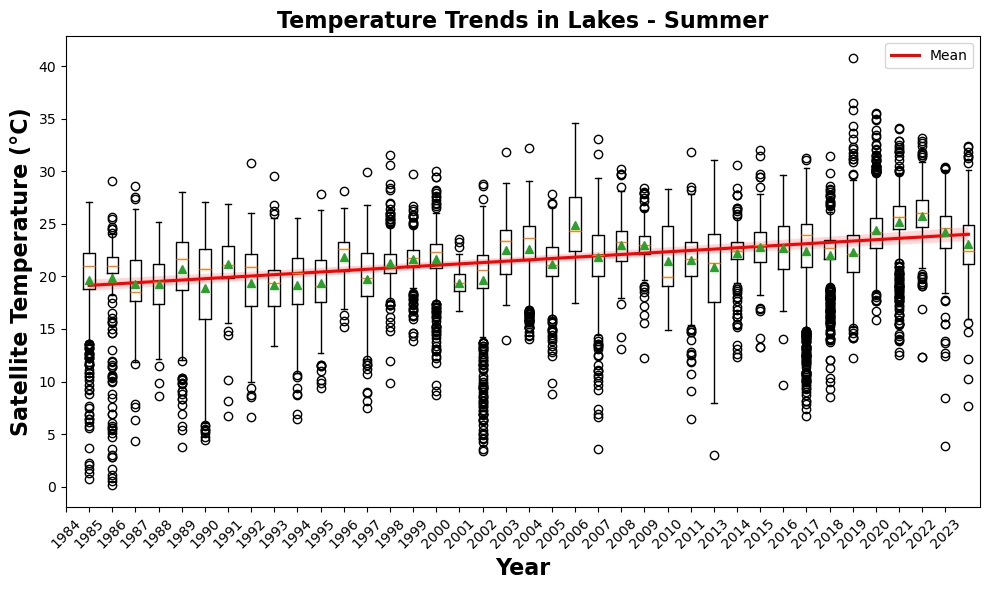

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

df_filtered_lakes['DATE_SMP'] = pd.to_datetime(df_filtered_lakes['DATE_SMP'])

# Filter the DataFrame for June, July, and August data
summer_data = df_filtered_lakes[(df_filtered_lakes['DATE_SMP'].dt.month.isin([6, 7, 8])) & (df_filtered_lakes['temp_mean'] >= 0)]

# Group the summer data by year
selected_lakes_summer_data_grouped = summer_data.groupby(summer_data['DATE_SMP'].dt.year)

# Calculate mean temperatures for each year
mean_temperatures = [group['temp_mean'].mean() for _, group in selected_lakes_summer_data_grouped]
years = list(selected_lakes_summer_data_grouped.groups.keys())

# Extracting data for box plot
box_plot_data = [group['temp_mean'] for _, group in selected_lakes_summer_data_grouped]

# Plotting
plt.figure(figsize=(10, 6))

# Plotting box plot with Seaborn
plt.boxplot(box_plot_data, labels=years, showmeans=True)

# Plotting mean line with Seaborn
sns.regplot(x=np.arange(len(mean_temperatures)) + 1, y=mean_temperatures, scatter=False, color='red', label='Mean')

# Adding labels and title
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Satellite Temperature (°C)', fontsize=16, fontweight='bold')
plt.title('Temperature Trends in Lakes - Summer', fontsize=16, fontweight='bold')
plt.xticks(range(len(years)), years, rotation=45)
plt.tight_layout()
plt.legend()

# Perform hypothesis test and print p-value
slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(mean_temperatures)) + 1, mean_temperatures)
print(f"The regression line is statistically significant (p < 0.05) with p-value: {p_value:.4f}.")

plt.show()


The regression line is statistically significant (p < 0.05) with p-value: 0.0000.


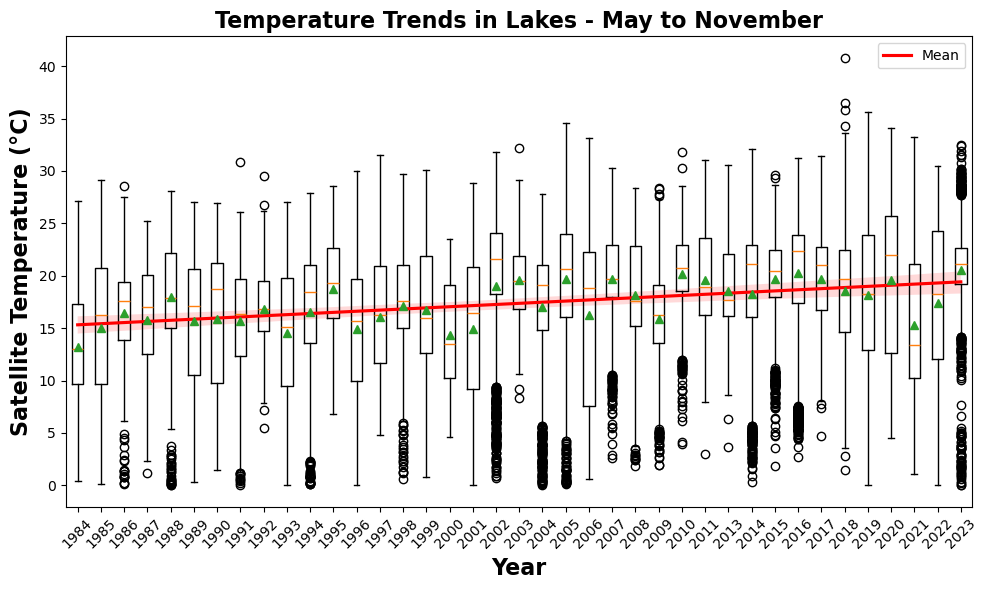

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

df_filtered_lakes['DATE_SMP'] = pd.to_datetime(df_filtered_lakes['DATE_SMP'])

# Filter the DataFrame for May to November data
may_to_nov_data = df_filtered_lakes[df_filtered_lakes['DATE_SMP'].dt.month.isin([5, 6, 7, 8, 9, 10, 11])]
selected_lakes_data = may_to_nov_data[may_to_nov_data['temp_mean'] >= 0]

# Group the data by year
selected_lakes_grouped = selected_lakes_data.groupby(selected_lakes_data['DATE_SMP'].dt.year)

# Calculate mean temperatures for each year
mean_temperatures = [group['temp_mean'].mean() for _, group in selected_lakes_grouped]
years = list(selected_lakes_grouped.groups.keys())

# Extracting data for box plot
box_plot_data = [group['temp_mean'] for _, group in selected_lakes_grouped]

# Plotting
plt.figure(figsize=(10, 6))

# Plotting box plot with Seaborn
plt.boxplot(box_plot_data, labels=years, showmeans=True)

# Plotting mean line with Seaborn
sns.regplot(x=np.arange(len(mean_temperatures)) + 1, y=mean_temperatures, scatter=False, color='red', label='Mean')

# Adding labels and title
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Satellite Temperature (°C)', fontsize=16, fontweight='bold')
plt.title('Temperature Trends in Lakes - May to November', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Perform hypothesis test and print p-value
slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(mean_temperatures)) + 1, mean_temperatures)
print(f"The regression line is statistically significant (p < 0.05) with p-value: {p_value:.4f}.")

plt.show()


In [11]:
# Define the file path for the Excel file
excel_file_path = 'Landsat_5_8_199_Lakes_4112024.xlsx'

# Export the DataFrame to Excel
df_filtered_lakes.to_excel(excel_file_path, index=False)

print("DataFrame successfully exported to Excel file:", excel_file_path)


DataFrame successfully exported to Excel file: Landsat_5_8_199_Lakes_4112024.xlsx
